# **Libraries and Settings**


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# **Data Import and Splitting**

In [2]:
df =  pd.read_excel('/content/BD.xlsx', sheet_name='T')
X_train_balanced = pd.read_excel('/content/X_train_balanced.xlsx')
y_train_balanced = pd.read_excel('/content/y_train_balanced.xlsx')

# Define input (X) and output (y) columns
X = df.drop(columns=['CO [%vol]', 'CO2 [%vol]', 'CH4 [%vol]', 'H2 [%vol]'])
y = df[['CO [%vol]', 'CO2 [%vol]', 'CH4 [%vol]', 'H2 [%vol]']]

# First split: separate 18.57% for validation and the remaining (81.43%) for train+test
X_temp, X_val, y_temp, y_val = train_test_split(X, y, test_size=0.1857, random_state=42)

# Second split: separate training (65.17% of the original total, which is approx. 80% of temp) and test (16.25% of the original total, approx. 20% of temp)
# We calculate the training proportion relative to the temporary set (train+test)
# train_proportion_in_temp = 0.6517 / (1 - 0.1857) ≈ 0.7999
X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=0.20, random_state=42) # Using 0.20 (20%) of temp set for test, leaving 80% for training

# Checking dataset sizes
print(f'Training set size: {X_train.shape[0]} ({X_train.shape[0]/df.shape[0]:.2%})')
print(f'Test set size: {X_test.shape[0]} ({X_test.shape[0]/df.shape[0]:.2%})')
print(f'Validation set size: {X_val.shape[0]} ({X_val.shape[0]/df.shape[0]:.2%})')
print(f'Training_SMOGN_X set size: {X_train_balanced.shape[0]}')
print(f'Training_SMOGN_y set size: {y_train_balanced.shape[0]}')

Training set size: 378 (65.06%)
Test set size: 95 (16.35%)
Validation set size: 108 (18.59%)
Training_SMOGN_X set size: 529
Training_SMOGN_y set size: 529


# **Development of the Random Forest Model**

A Random Forest Regressor was implemented to predict all syngas components (CO, CO₂, CH₄, and H₂). Random Forest was selected for its robustness to overfitting, ability to model nonlinear relationships, and its built-in handling of feature importance and interaction effects.



## **Functions**

In [3]:
def show_metrics(set, y, y_pred):

  r2 = r2_score(y, y_pred, multioutput='variance_weighted')
  mse = mean_squared_error(y, y_pred)
  mae = mean_absolute_error(y, y_pred)

  print(f"\n{set.capitalize()} set evaluation:")
  print(f"R² ({set}): {r2:.4f}")
  print(f"MSE ({set}): {mse:.4f}")
  print(f"MAE ({set}): {mae:.4f}")

  print(f"\nPer-output metrics ({set} set):")
  output_cols = y.columns
  for i, col in enumerate(output_cols):
      r2_single = r2_score(y[col], y_pred[:, i])
      mse_single = mean_squared_error(y[col], y_pred[:, i])
      mae_single = mean_absolute_error(y[col], y_pred[:, i])
      sse_single = np.sum((y[col] - y_pred[:, i])**2)
      print(f"- {col}: R² = {r2_single:.4f}, MSE = {mse_single:.4f}, MAE = {mae_single:.4f}, SSE = {sse_single:.4f}")

## **Random Forest Model Without SMOGN Application**

### **First Random Forest Model**

The first model was built using the RandomForestRegressor from the scikit-learn library. Since the problem involves predicting multiple gas concentrations simultaneously (CO, CO₂, CH₄, and H₂), the regression model was applied directly to a multivariate target. To improve predictive performance, a hyperparameter search was carried out using GridSearchCV, which systematically explores a predefined parameter grid. The selected hyperparameters were:

* n_estimators (number of trees): [100, 200]

* max_depth (tree depth): [10, 20, None]

* max_features (number of features considered at each split): ['sqrt', 'log2']

* min_samples_split (minimum number of samples to split an internal node): [2, 5]

A 5-fold cross-validation was employed to evaluate each combination of hyperparameters using the R² score as the optimization metric. After selecting the best combination, the model was evaluated on the validation and test datasets using multiple regression metrics: R², mean squared error (MSE), mean absolute error (MAE), and sum of squared errors (SSE).

In [4]:
# 1. Define the base Random Forest model
rf_base = RandomForestRegressor(random_state=42)

# 2. Define the hyperparameter search space for random search
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5]
}

# 3. Set up the GridSearchCV (efficient hyperparameter search)
grid_search = GridSearchCV(estimator=rf_base,
                           param_grid=param_grid,
                           scoring='r2', # Main evaluation metric: R²
                           cv=5,         # 5-fold cross-validation
                           n_jobs=-1,    # Use all available cores
                           verbose=2)

# 4. Fit the model to the training data
print("Starting hyperparameter search with GridSearchCV...")
grid_search.fit(X_train, y_train)
print("Search completed.")

# 5. Display the best hyperparameters found
print("\nBest hyperparameters found:")
print(grid_search.best_params_)
best_model = grid_search.best_estimator_
show_metrics("train", y_train, best_model.predict(X_train))

# 6. Evaluate the best model on the validation set
y_val_pred = best_model.predict(X_val)
show_metrics("validation", y_val, y_val_pred)

# 7. Final evaluation on the test set
y_test_pred = best_model.predict(X_test)
show_metrics("test", y_test, y_test_pred)

Starting hyperparameter search with GridSearchCV...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Search completed.

Best hyperparameters found:
{'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200}

Train set evaluation:
R² (train): 0.9566
MSE (train): 5.6018
MAE (train): 1.3556

Per-output metrics (train set):
- CO [%vol]: R² = 0.9201, MSE = 6.6096, MAE = 1.6204, SSE = 2498.4164
- CO2 [%vol]: R² = 0.9724, MSE = 3.0709, MAE = 1.1710, SSE = 1160.8005
- CH4 [%vol]: R² = 0.8644, MSE = 2.4111, MAE = 0.7964, SSE = 911.4133
- H2 [%vol]: R² = 0.9662, MSE = 10.3154, MAE = 1.8348, SSE = 3899.2178

Validation set evaluation:
R² (validation): 0.8708
MSE (validation): 15.8579
MAE (validation): 2.3579

Per-output metrics (validation set):
- CO [%vol]: R² = 0.7594, MSE = 19.9635, MAE = 2.8625, SSE = 2156.0584
- CO2 [%vol]: R² = 0.8845, MSE = 12.6169, MAE = 2.3770, SSE = 1362.6243
- CH4 [%vol]: R² = 0.8868, MSE = 1.5787, MAE = 0.8603, SSE = 170.5047
-

The hyperparameter search yielded the following optimal configuration for the base model:

```
{'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200}
```
On the validation set, the model achieved an overall:

* R² = 0.8708
* MSE = 15.8579
* MAE = 2.3579

On the test set, the performance slightly decreased, with:

* R² = 0.8360
* MSE = 22.8779
* MAE = 2.6901

A closer look at the per-output metrics revealed that the model performed better on H₂ and CO₂ (R² ≈ 0.89 and 0.87 respectively) but had lower predictive power for CH₄ and especially CO (R² ≈ 0.64 and 0.76respectively). This suggested the need for further optimization, particularly in terms of model architecture and hyperparameter flexibility.

### **Optimization of the First Random Forest Model**

To improve the model's accuracy and generalization capabilities, several enhancements were introduced:

1. MultiOutputRegressor: The RandomForestRegressor was wrapped in MultiOutputRegressor to train a separate model for each output variable. This approach allows the model to specialize on each target independently, which can improve performance when outputs behave differently.

2. RandomizedSearchCV: The previous GridSearchCV was replaced with RandomizedSearchCV, allowing the exploration of a larger and more diverse hyperparameter space in a computationally efficient manner. The new hyperparameter distributions included:

  * n_estimators: random integers between 100 and 300
  * max_depth: [10, 20, 30, None]
  * max_features: ['sqrt', 'log2', 0.5]
  * min_samples_split: [2, 5, 10]
  * min_samples_leaf: [1, 2, 4]
  * bootstrap: [True, False]

This more flexible and randomized approach improves the chances of finding better hyperparameters without exhaustive enumeration.

In [5]:
# 1. Define the base Random Forest model
# We use a base RandomForest, which will be replicated one per output using MultiOutputRegressor
base_rf = RandomForestRegressor(random_state=42)
# Wrap the base model into MultiOutputRegressor to handle multi-target regression
multi_rf = MultiOutputRegressor(base_rf)

# 2. Define the hyperparameter search space for random search
# We use scipy.stats.randint to define value ranges
param_dist = {
    'estimator__n_estimators': randint(100, 300),
    'estimator__max_depth': [10, 20, 30, None],
    'estimator__max_features': ['sqrt', 'log2', 0.5],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__min_samples_leaf': [1, 2, 4],
    'estimator__bootstrap': [True, False]
}

# 3. Set up the RandomizedSearchCV (efficient hyperparameter search)
random_search = RandomizedSearchCV(estimator=multi_rf,
                                   param_distributions=param_dist,
                                   n_iter=50,            # Number of random combinations to try
                                   scoring='r2',         # Main evaluation metric: R²
                                   cv=5,                 # 5-fold cross-validation
                                   n_jobs=-1,            # Use all available cores
                                   verbose=2,
                                   random_state=42)

# 4. Fit the model to the training data
print("Starting hyperparameter search with RandomizedSearchCV...")
random_search.fit(X_train, y_train)
print("Search completed.")

# 5. Display the best hyperparameters found
print("\nBest hyperparameters found:")
print(random_search.best_params_)
best_model = random_search.best_estimator_
show_metrics("train", y_train, best_model.predict(X_train))

# 6. Evaluate the best model on the validation set
y_val_pred = best_model.predict(X_val)
show_metrics("validation", y_val, y_val_pred)

# 7. Final evaluation on the test set
y_test_pred = best_model.predict(X_test)
show_metrics("test", y_test, y_test_pred)

Starting hyperparameter search with RandomizedSearchCV...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Search completed.

Best hyperparameters found:
{'estimator__bootstrap': False, 'estimator__max_depth': None, 'estimator__max_features': 'sqrt', 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 5, 'estimator__n_estimators': 285}

Train set evaluation:
R² (train): 0.9564
MSE (train): 5.6252
MAE (train): 1.3301

Per-output metrics (train set):
- CO [%vol]: R² = 0.9229, MSE = 6.3777, MAE = 1.5583, SSE = 2410.7550
- CO2 [%vol]: R² = 0.9687, MSE = 3.4818, MAE = 1.2055, SSE = 1316.1056
- CH4 [%vol]: R² = 0.8595, MSE = 2.4985, MAE = 0.8061, SSE = 944.4290
- H2 [%vol]: R² = 0.9667, MSE = 10.1429, MAE = 1.7503, SSE = 3834.0149

Validation set evaluation:
R² (validation): 0.8689
MSE (validation): 16.0883
MAE (validation): 2.3146

Per-output metrics (validation set):
- CO [%vol]: R² = 0.7455, MSE = 21.1181, MAE = 2.8469, SSE = 2280.7576
- CO2 [%vol]: R² = 0.8830,

The optimized model found the following hyperparameters as optimal:

```
{'estimator__bootstrap': False, 'estimator__max_depth': None, 'estimator__max_features': 'sqrt',
 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 5, 'estimator__n_estimators': 285}
```

The validation set performance slightly improved in terms of MAE:

* R² = 0.8689
* MSE = 16.0883
* MAE = 2.3146

More importantly, on the test set, the model achieved noticeably better generalization:

* R² = 0.8505 (vs. 0.8360)
* MSE = 20.8526 (vs. 22.8779)
* MAE = 2.5684 (vs. 2.6901)

Per-output improvements:

* CO: R² increased from 0.6669 to 0.7193
* CH₄: R² increased from 0.6381 to 0.6856
* H₂ and CO₂ also showed slight improvements

These results confirm that the optimized model is better than the original:

* The use of MultiOutputRegressor allowed more tailored predictions for each output.
* The expanded and randomized hyperparameter search improved the model's ability to generalize on unseen data.
* The improvements are especially visible in the outputs that previously underperformed (CO and CH₄), which now show higher R² and lower error values.


/tmp/ipython-input-6-408883872.py:40: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


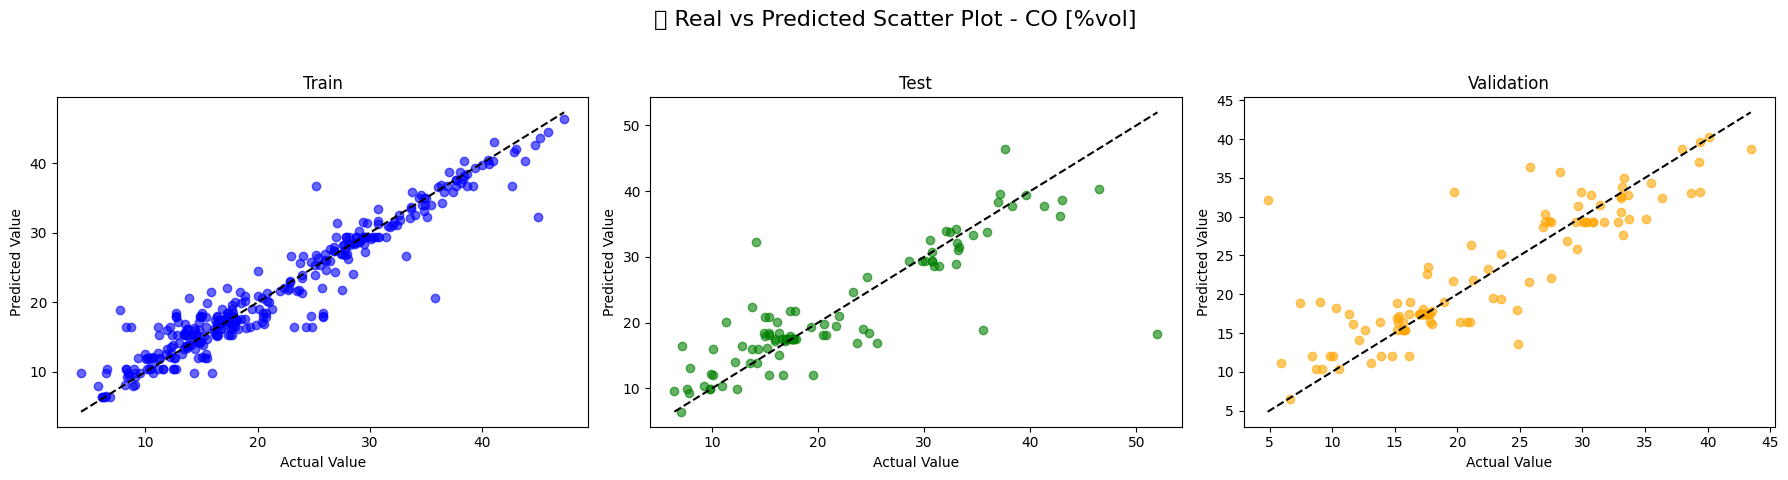

/tmp/ipython-input-6-408883872.py:63: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


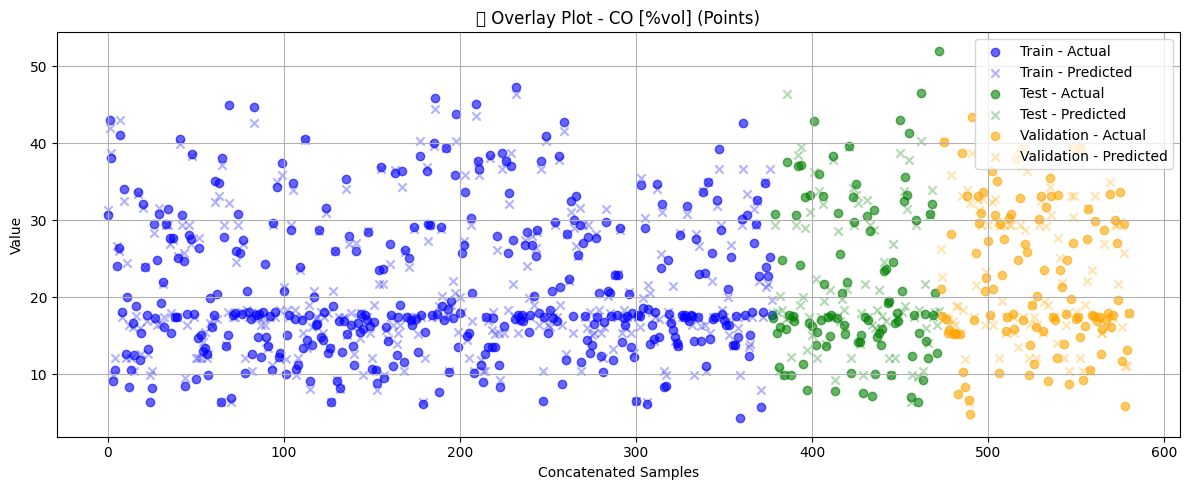

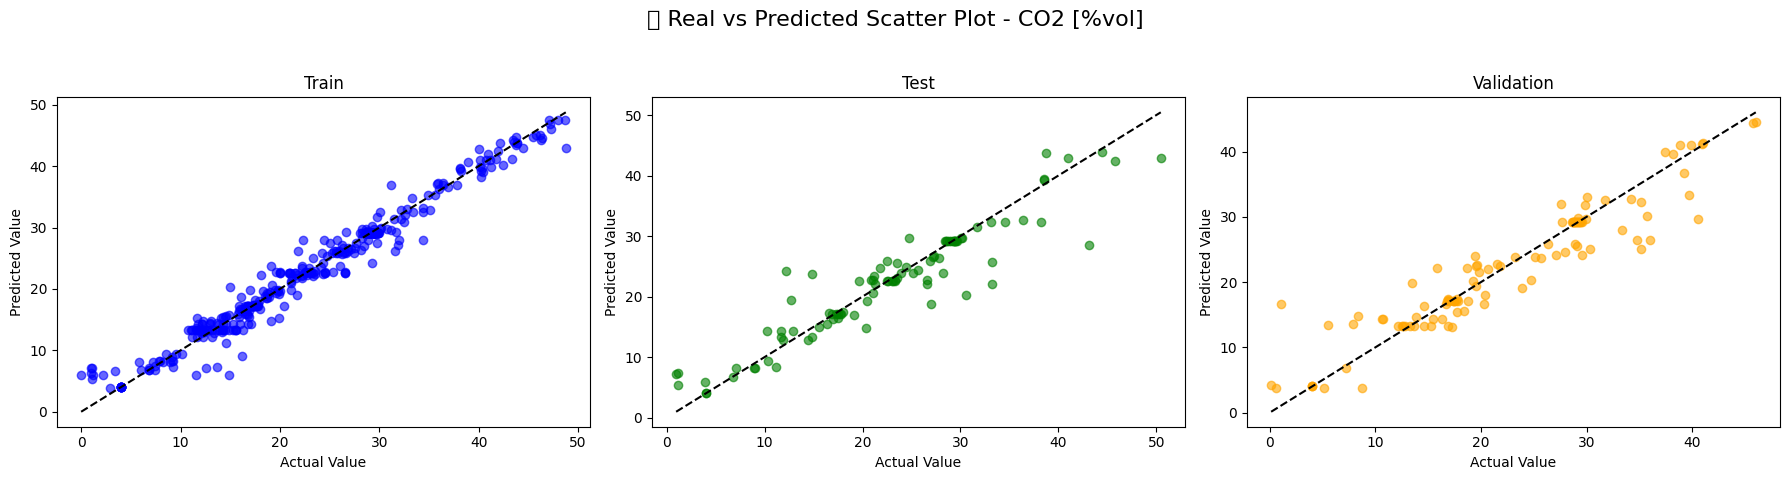

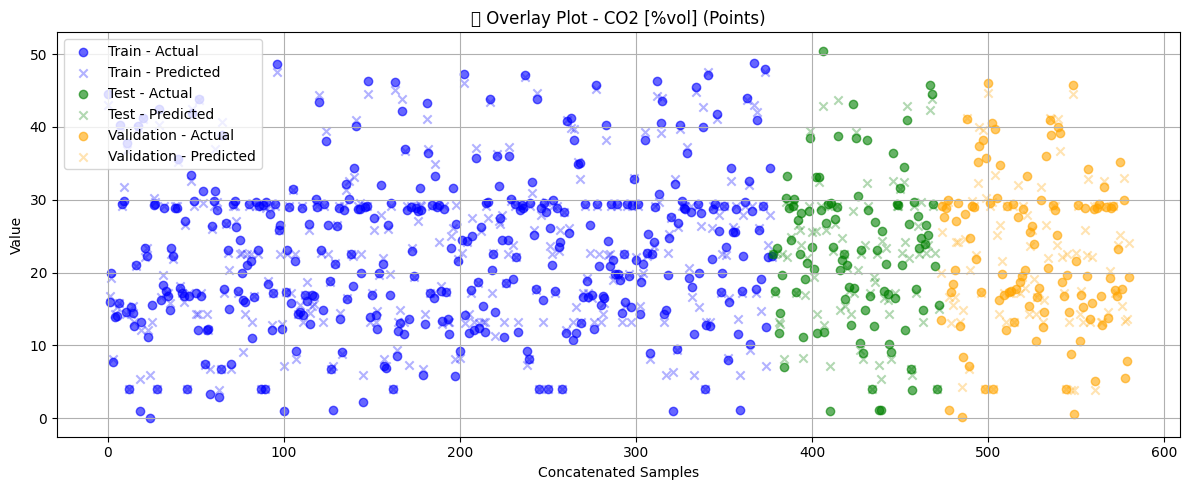

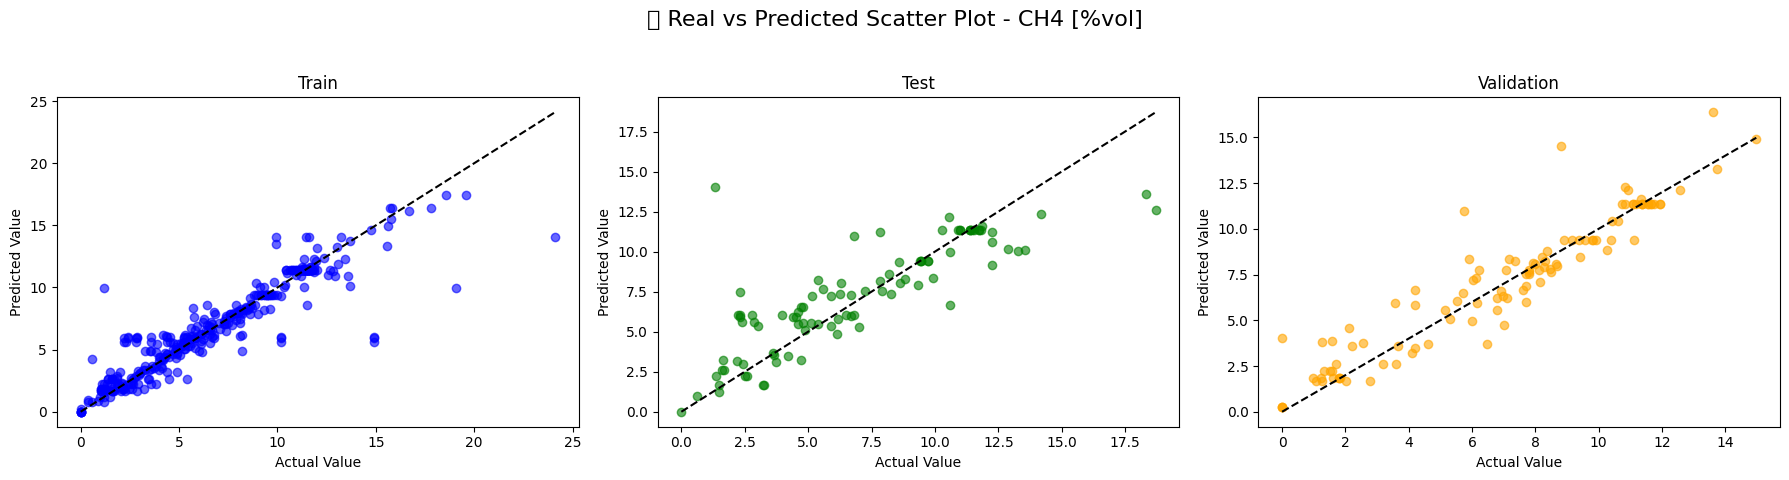

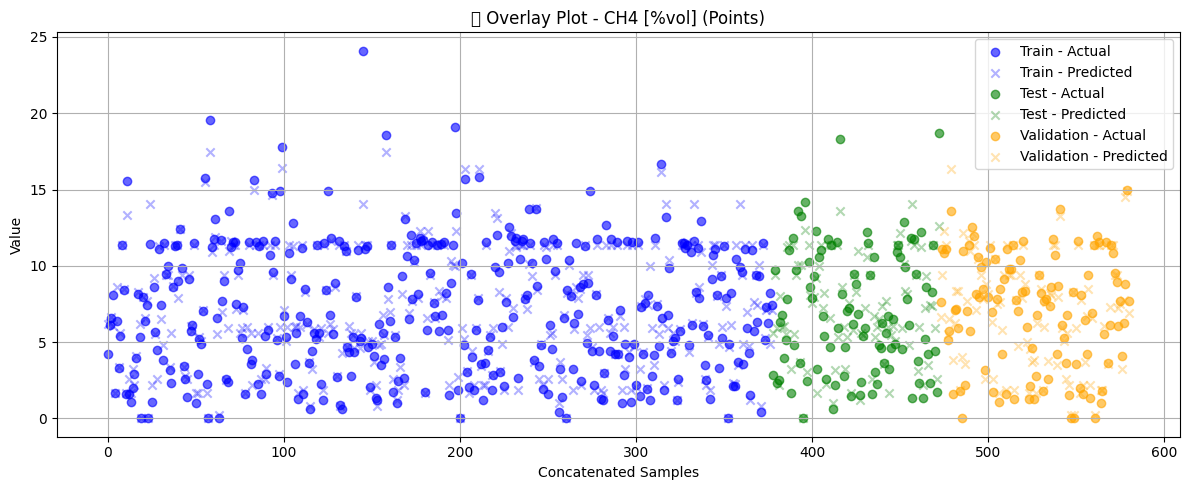

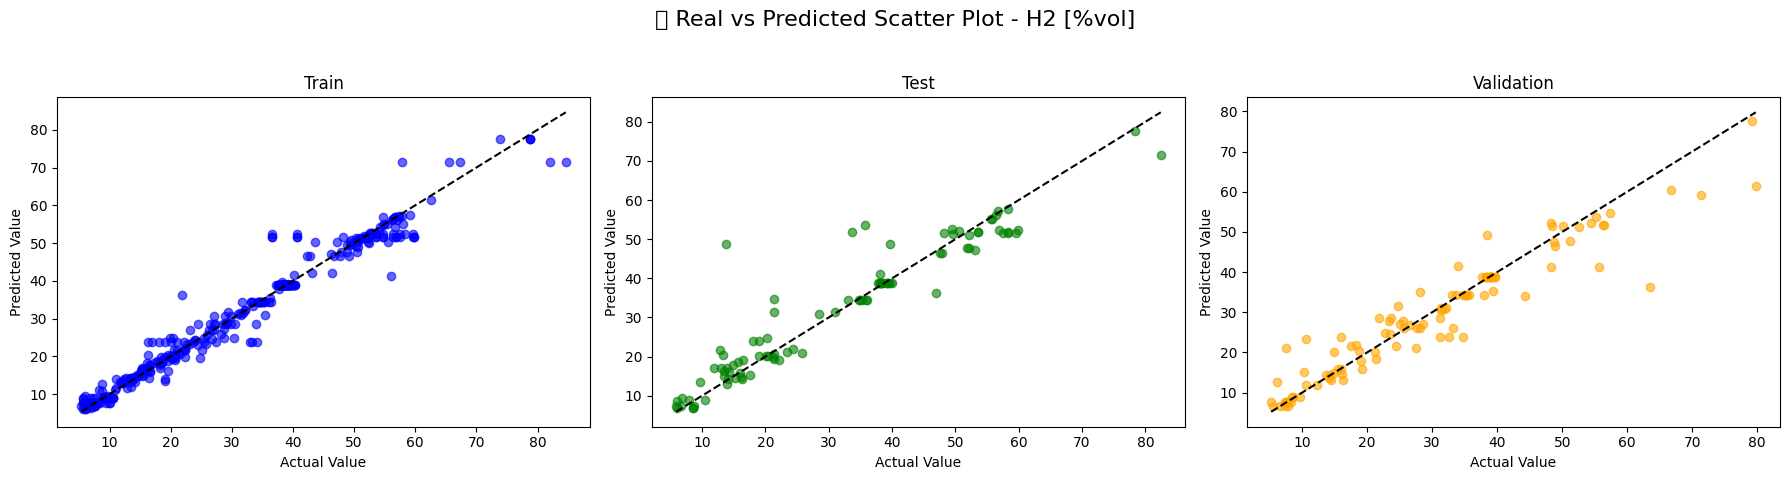

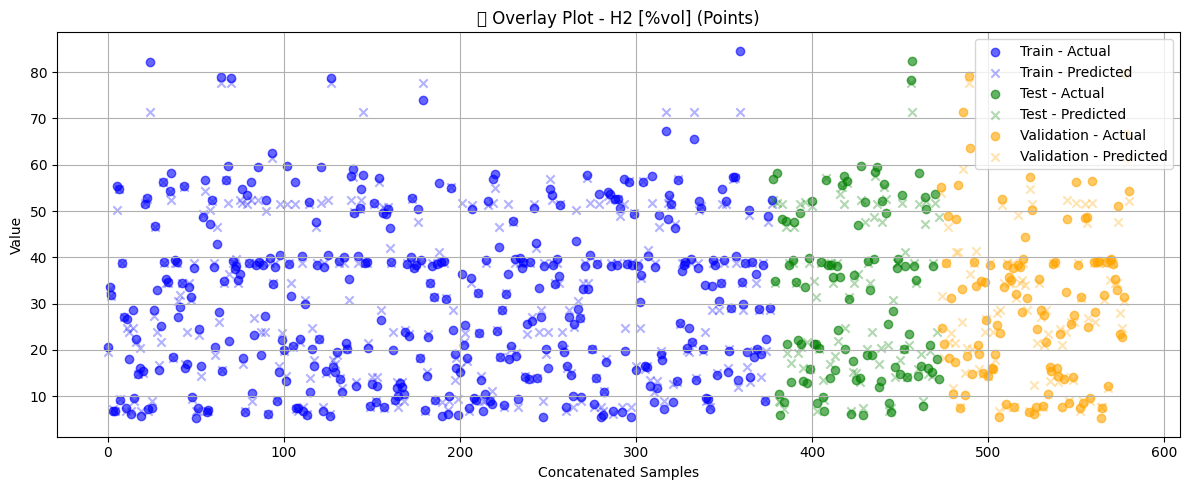

In [6]:
# Make predictions on all sets
y_pred_tr = best_model.predict(X_train)
y_pred_te = best_model.predict(X_test)
y_pred_val = best_model.predict(X_val)

# Loop through each output (e.g., CO, CO2, etc.)
output_cols = y_train.columns

for i, comp in enumerate(output_cols):
    y_tr = y_train[comp].values
    y_te = y_test[comp].values
    y_val_ = y_val[comp].values

    pred_tr = y_pred_tr[:, i]
    pred_te = y_pred_te[:, i]
    pred_val = y_pred_val[:, i]

    # ==== Scatter Plot ====
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f"📈 Real vs Predicted Scatter Plot - {comp}", fontsize=16)

    axs[0].scatter(y_tr, pred_tr, color='blue', alpha=0.6)
    axs[0].plot([y_tr.min(), y_tr.max()], [y_tr.min(), y_tr.max()], 'k--')
    axs[0].set_title('Train')
    axs[0].set_xlabel('Actual Value')
    axs[0].set_ylabel('Predicted Value')

    axs[1].scatter(y_te, pred_te, color='green', alpha=0.6)
    axs[1].plot([y_te.min(), y_te.max()], [y_te.min(), y_te.max()], 'k--')
    axs[1].set_title('Test')
    axs[1].set_xlabel('Actual Value')
    axs[1].set_ylabel('Predicted Value')

    axs[2].scatter(y_val_, pred_val, color='orange', alpha=0.6)
    axs[2].plot([y_val_.min(), y_val_.max()], [y_val_.min(), y_val_.max()], 'k--')
    axs[2].set_title('Validation')
    axs[2].set_xlabel('Actual Value')
    axs[2].set_ylabel('Predicted Value')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # ==== Overlay Plot with Points ====
    plt.figure(figsize=(12, 5))

    idx_te = np.arange(len(y_tr), len(y_tr) + len(y_te))
    idx_val = np.arange(len(y_tr) + len(y_te), len(y_tr) + len(y_te) + len(y_val_))

    plt.scatter(range(len(y_tr)), y_tr, label='Train - Actual', color='blue', alpha=0.6, marker='o')
    plt.scatter(range(len(y_tr)), pred_tr, label='Train - Predicted', color='blue', alpha=0.3, marker='x')

    plt.scatter(idx_te, y_te, label='Test - Actual', color='green', alpha=0.6, marker='o')
    plt.scatter(idx_te, pred_te, label='Test - Predicted', color='green', alpha=0.3, marker='x')

    plt.scatter(idx_val, y_val_, label='Validation - Actual', color='orange', alpha=0.6, marker='o')
    plt.scatter(idx_val, pred_val, label='Validation - Predicted', color='orange', alpha=0.3, marker='x')

    plt.title(f'📉 Overlay Plot - {comp} (Points)')
    plt.xlabel('Concatenated Samples')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## **Random Forest Model With SMOGN Application**

In [7]:
# 1. Define the base Random Forest model
# We use a base RandomForest, which will be replicated one per output using MultiOutputRegressor
base_rf = RandomForestRegressor(random_state=42)
# Wrap the base model into MultiOutputRegressor to handle multi-target regression
multi_rf = MultiOutputRegressor(base_rf)

# 2. Define the hyperparameter search space for random search
# We use scipy.stats.randint to define value ranges
param_dist = {
    'estimator__n_estimators': randint(100, 300),
    'estimator__max_depth': [10, 20, 30, None],
    'estimator__max_features': ['sqrt', 'log2', 0.5],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__min_samples_leaf': [1, 2, 4],
    'estimator__bootstrap': [True, False]
}

# 3. Set up the RandomizedSearchCV (efficient hyperparameter search)
random_search = RandomizedSearchCV(estimator=multi_rf,
                                   param_distributions=param_dist,
                                   n_iter=50,            # Number of random combinations to try
                                   scoring='r2',         # Main evaluation metric: R²
                                   cv=5,                 # 5-fold cross-validation
                                   n_jobs=-1,            # Use all available cores
                                   verbose=2,
                                   random_state=42)

# 4. Fit the model to the training data
print("Starting hyperparameter search with RandomizedSearchCV...")
random_search.fit(X_train_balanced, y_train_balanced)
print("Search completed.")

# 5. Display the best hyperparameters found
print("\nBest hyperparameters found:")
print(random_search.best_params_)
best_model = random_search.best_estimator_
show_metrics("train", y_train_balanced, best_model.predict(X_train_balanced))

# 6. Evaluate the best model on the validation set
y_val_pred = best_model.predict(X_val)
show_metrics("validation", y_val, y_val_pred)

# 7. Final evaluation on the test set
y_test_pred = best_model.predict(X_test)
show_metrics("test", y_test, y_test_pred)

Starting hyperparameter search with RandomizedSearchCV...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Search completed.

Best hyperparameters found:
{'estimator__bootstrap': False, 'estimator__max_depth': None, 'estimator__max_features': 'sqrt', 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 5, 'estimator__n_estimators': 285}

Train set evaluation:
R² (train): 0.9698
MSE (train): 5.4521
MAE (train): 1.1473

Per-output metrics (train set):
- CO [%vol]: R² = 0.9645, MSE = 4.3147, MAE = 1.1998, SSE = 2282.4551
- CO2 [%vol]: R² = 0.9767, MSE = 2.8584, MAE = 0.9892, SSE = 1512.0718
- CH4 [%vol]: R² = 0.9312, MSE = 1.8421, MAE = 0.6198, SSE = 974.4855
- H2 [%vol]: R² = 0.9717, MSE = 12.7934, MAE = 1.7805, SSE = 6767.7076

Validation set evaluation:
R² (validation): 0.8579
MSE (validation): 17.4480
MAE (validation): 2.3297

Per-output metrics (validation set):
- CO [%vol]: R² = 0.7259, MSE = 22.7466, MAE = 2.8017, SSE = 2456.6281
- CO2 [%vol]: R² = 0.8878,

/tmp/ipython-input-8-342925866.py:40: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


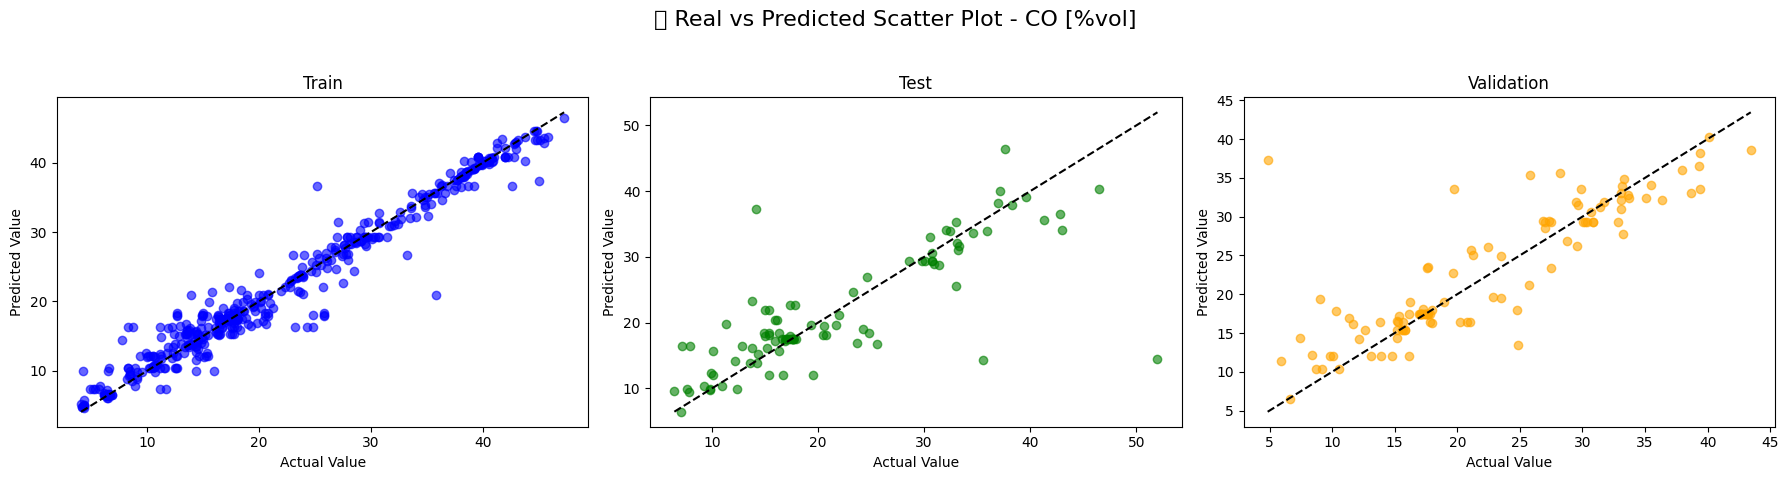

/tmp/ipython-input-8-342925866.py:63: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


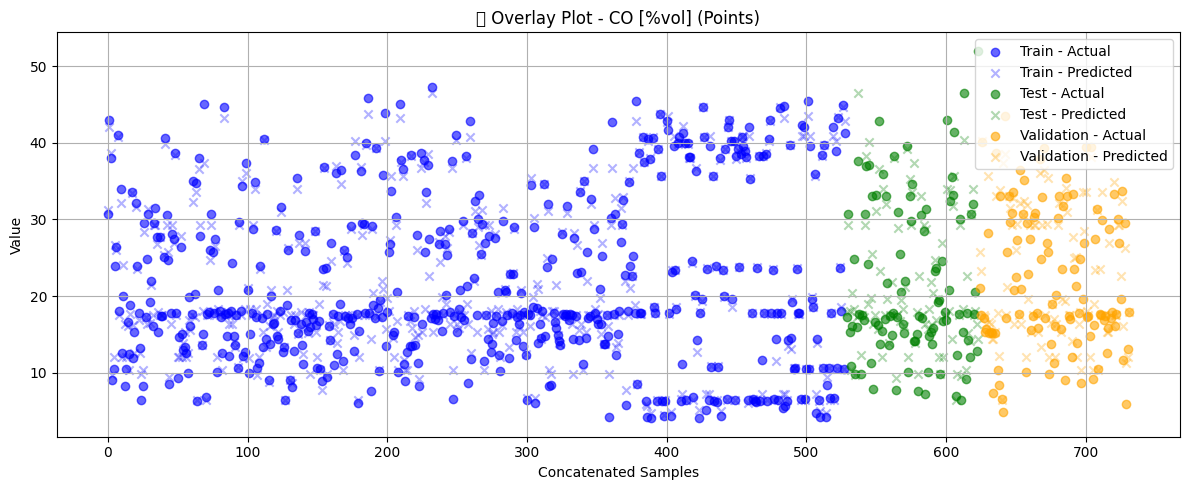

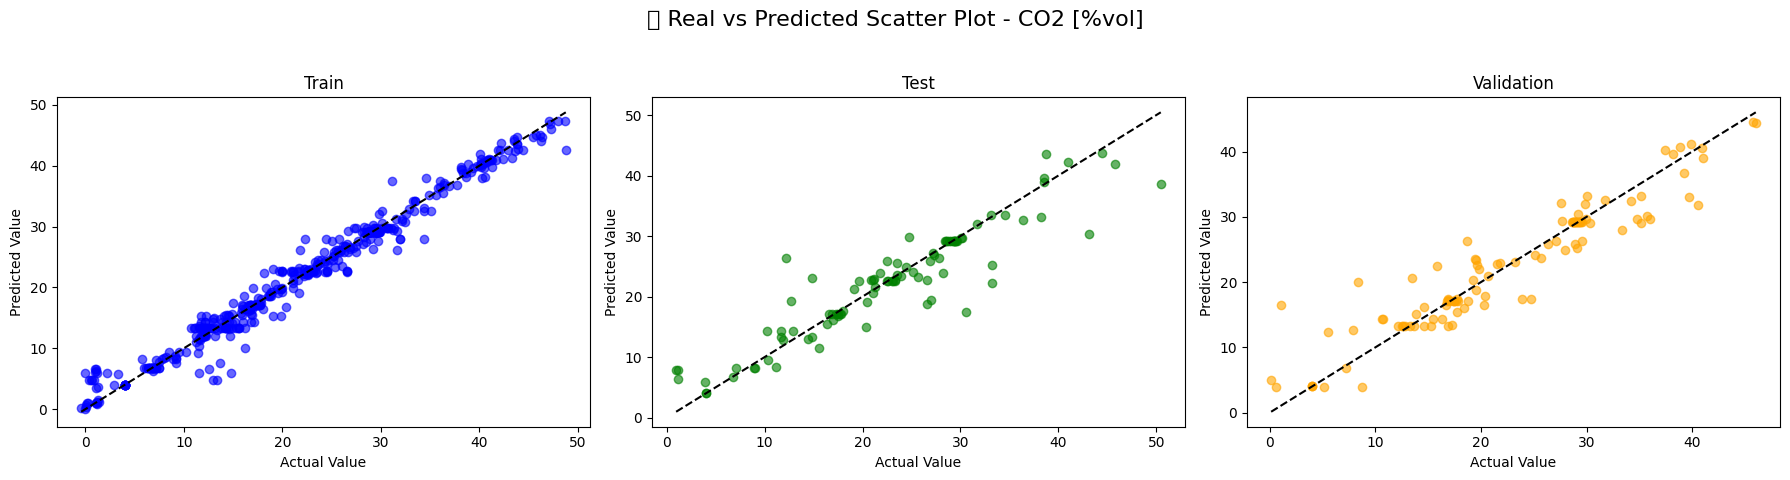

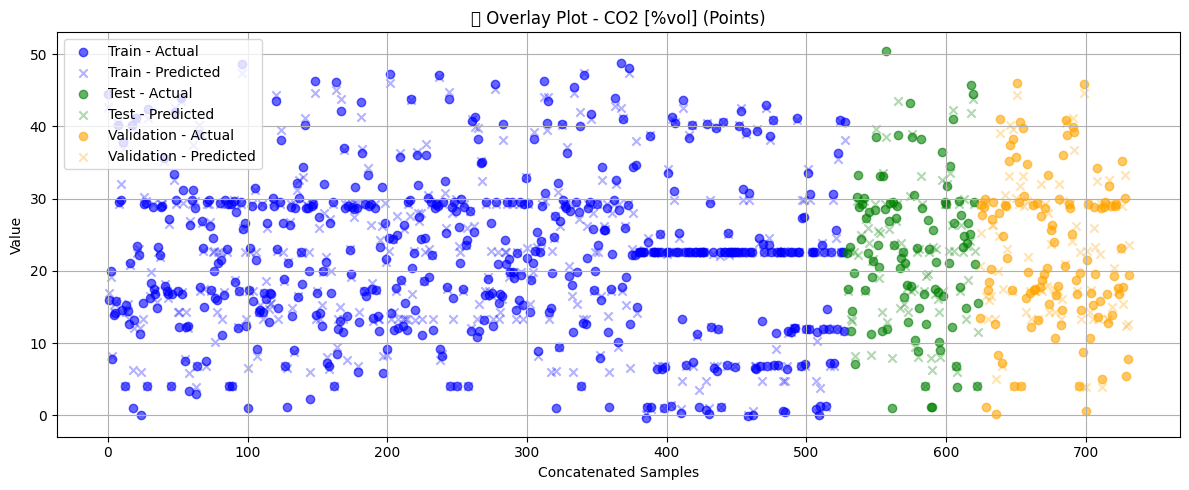

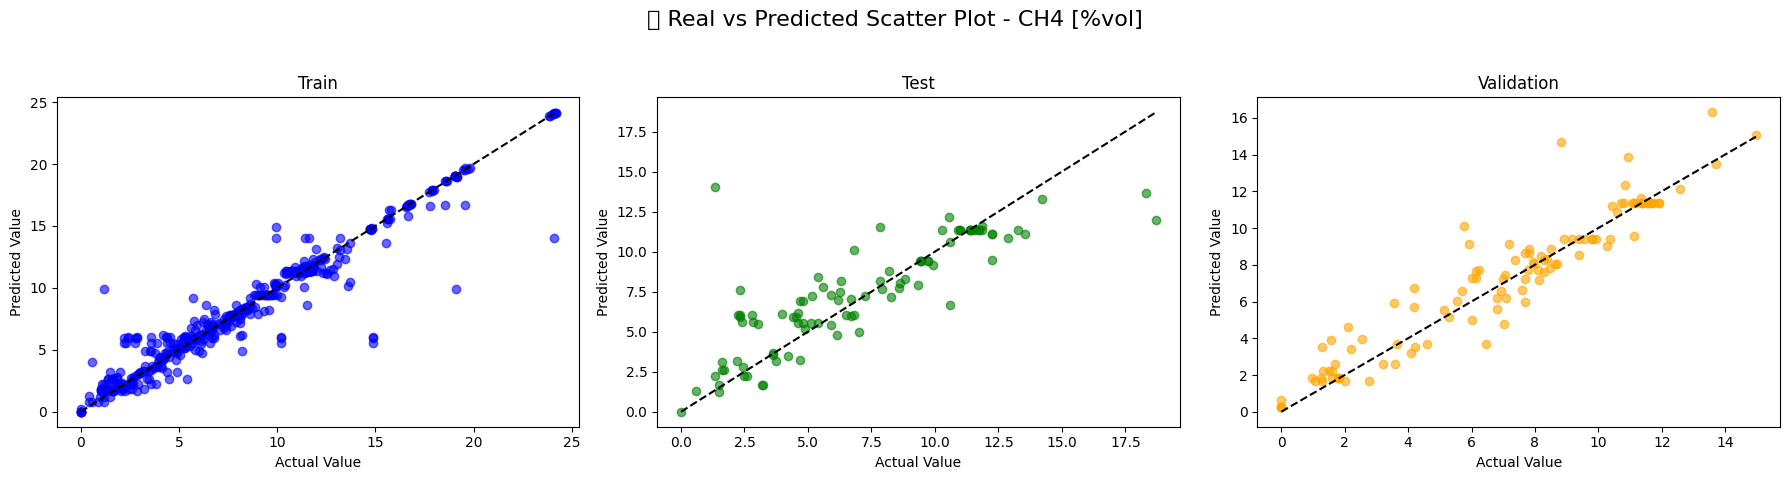

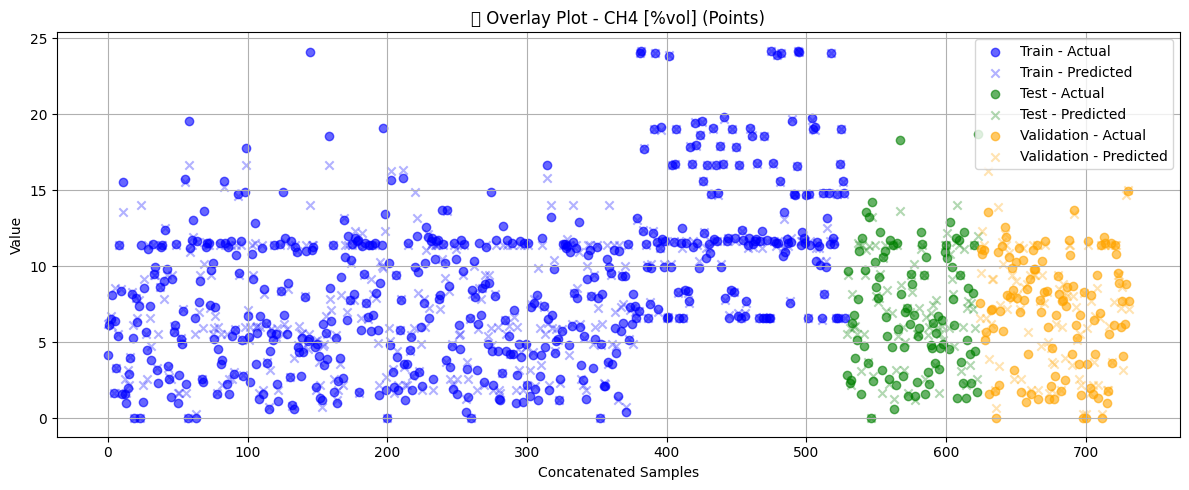

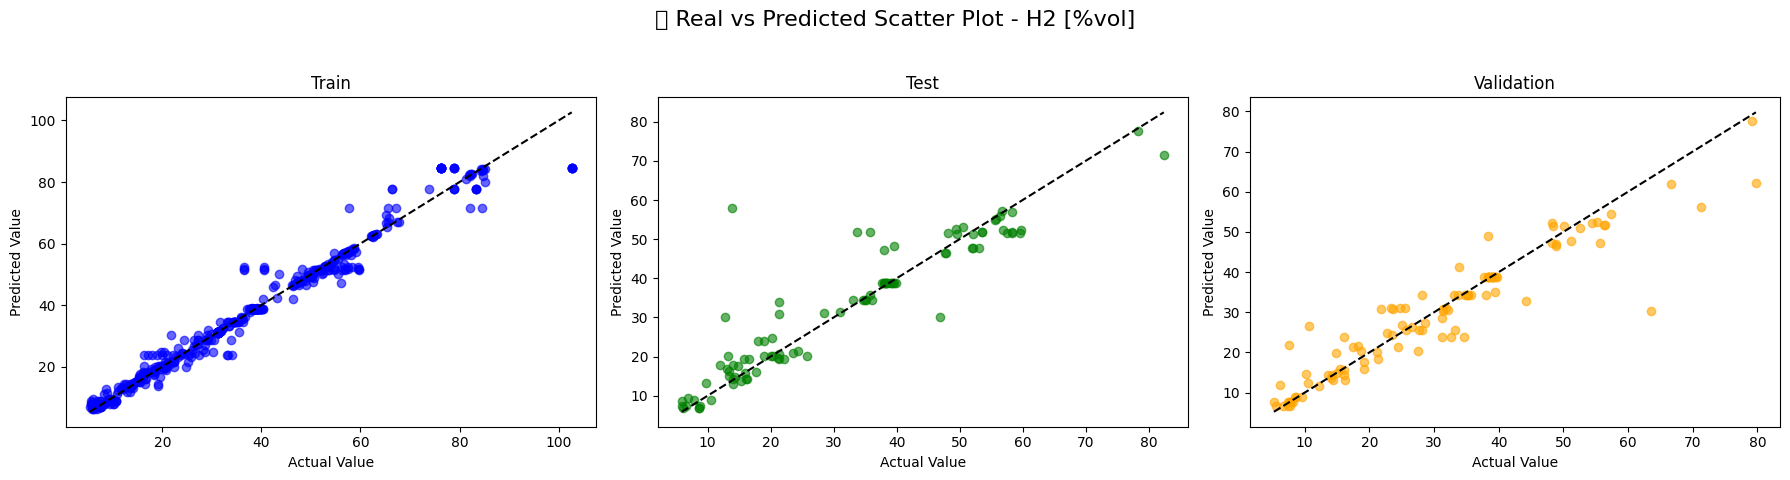

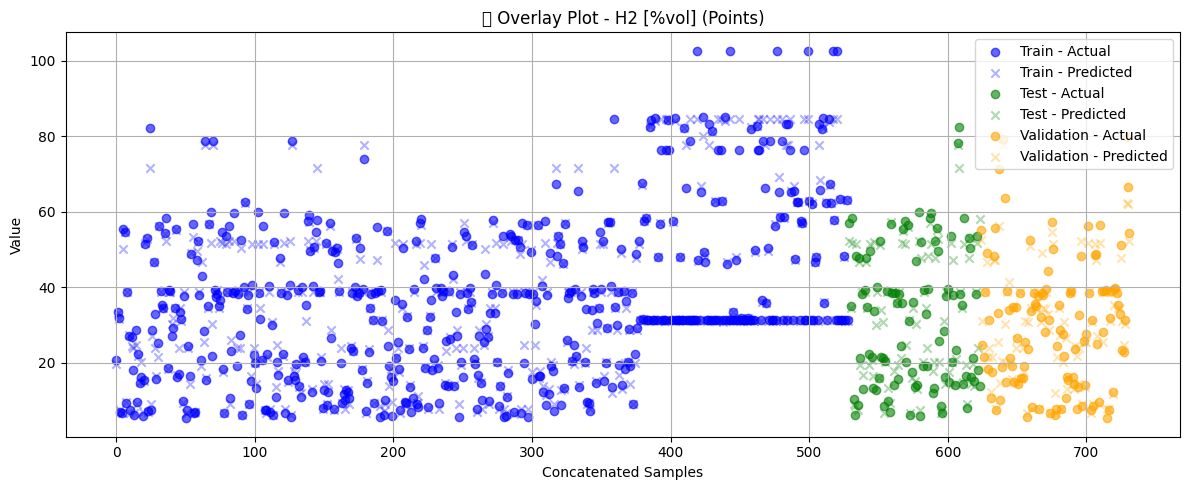

In [8]:
# Make predictions on all sets
y_pred_tr = best_model.predict(X_train_balanced)
y_pred_te = best_model.predict(X_test)
y_pred_val = best_model.predict(X_val)

# Loop through each output (e.g., CO, CO2, etc.)
output_cols = y_train_balanced.columns

for i, comp in enumerate(output_cols):
    y_tr = y_train_balanced[comp].values
    y_te = y_test[comp].values
    y_val_ = y_val[comp].values

    pred_tr = y_pred_tr[:, i]
    pred_te = y_pred_te[:, i]
    pred_val = y_pred_val[:, i]

    # ==== Scatter Plot ====
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f"📈 Real vs Predicted Scatter Plot - {comp}", fontsize=16)

    axs[0].scatter(y_tr, pred_tr, color='blue', alpha=0.6)
    axs[0].plot([y_tr.min(), y_tr.max()], [y_tr.min(), y_tr.max()], 'k--')
    axs[0].set_title('Train')
    axs[0].set_xlabel('Actual Value')
    axs[0].set_ylabel('Predicted Value')

    axs[1].scatter(y_te, pred_te, color='green', alpha=0.6)
    axs[1].plot([y_te.min(), y_te.max()], [y_te.min(), y_te.max()], 'k--')
    axs[1].set_title('Test')
    axs[1].set_xlabel('Actual Value')
    axs[1].set_ylabel('Predicted Value')

    axs[2].scatter(y_val_, pred_val, color='orange', alpha=0.6)
    axs[2].plot([y_val_.min(), y_val_.max()], [y_val_.min(), y_val_.max()], 'k--')
    axs[2].set_title('Validation')
    axs[2].set_xlabel('Actual Value')
    axs[2].set_ylabel('Predicted Value')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # ==== Overlay Plot with Points ====
    plt.figure(figsize=(12, 5))

    idx_te = np.arange(len(y_tr), len(y_tr) + len(y_te))
    idx_val = np.arange(len(y_tr) + len(y_te), len(y_tr) + len(y_te) + len(y_val_))

    plt.scatter(range(len(y_tr)), y_tr, label='Train - Actual', color='blue', alpha=0.6, marker='o')
    plt.scatter(range(len(y_tr)), pred_tr, label='Train - Predicted', color='blue', alpha=0.3, marker='x')

    plt.scatter(idx_te, y_te, label='Test - Actual', color='green', alpha=0.6, marker='o')
    plt.scatter(idx_te, pred_te, label='Test - Predicted', color='green', alpha=0.3, marker='x')

    plt.scatter(idx_val, y_val_, label='Validation - Actual', color='orange', alpha=0.6, marker='o')
    plt.scatter(idx_val, pred_val, label='Validation - Predicted', color='orange', alpha=0.3, marker='x')

    plt.title(f'📉 Overlay Plot - {comp} (Points)')
    plt.xlabel('Concatenated Samples')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

**Carbon Monoxide (CO) Analysis**

The prediction of CO concentrations using the optimized Random Forest model reveals notable differences between the original and SMOGN-augmented datasets. In the model trained on the original data, the scatter plots for the training and validation sets show a strong alignment between actual and predicted values, with R² values of 0.9229 and 0.7455, respectively. However, the test set reveals a performance decline, with R² dropping to 0.7193 and a visible dispersion in the scatter plot. This suggests a degree of overfitting, where the model fits the training data well but loses generalization when applied to unseen data. In contrast, the model trained with SMOGN-augmented data shows a more even distribution of predictions across the range of CO concentrations in the overlay plot. While the test R² slightly decreases to 0.6307, the scatter plot indicates improved coverage of the higher and lower ends of the concentration range. This trade-off reflects a key benefit of SMOGN: better learning from underrepresented instances, even though it may introduce noise that reduces overall accuracy. The CO data likely suffers from an imbalanced distribution, with fewer samples at the extremes—making it a good candidate for SMOGN, though the benefit must be balanced against the slight loss in precision.

**Carbon Dioxide (CO₂) Analysis**

The prediction of CO₂ stands out as the most consistent and accurate across all gases and data augmentation strategies. When trained on the original dataset, the model achieves excellent R² scores across all splits (train: 0.9687, validation: 0.8830, test: 0.8703), indicating a strong ability to generalize. The scatter plots demonstrate tightly clustered points along the ideal diagonal line, and the overlay plots confirm accurate tracking of actual values across all phases. Notably, applying SMOGN does not lead to significant improvements. In fact, the test R² slightly declines to 0.8506, and while predictions remain accurate, the additional synthetic data do not contribute meaningfully. This is likely because CO₂ values are well-represented in the original dataset across the concentration range, making data augmentation unnecessary. Consequently, CO₂ prediction is already robust without requiring special balancing techniques. These results emphasize that augmentation methods like SMOGN are best reserved for targets with skewed or underrepresented distributions, and may not benefit balanced outputs.

**Methane (CH₄) Analysis**

CH₄ prediction reveals meaningful improvements when using SMOGN-augmented data. The original dataset model yields reasonable accuracy, with R² scores of 0.8595, 0.8792, and 0.6856 for train, validation, and test sets, respectively. The test R², however, indicates a weaker generalization capability compared to other gases. The scatter plots show a wider spread in the test set, particularly for low CH₄ concentrations, where the model tends to underpredict. When the model is trained using the SMOGN-augmented dataset, test set R² slightly improves to 0.6928, and the scatter plot shows better alignment, especially in the lower concentration range. This improvement suggests that SMOGN effectively addresses the imbalance in CH₄ data, particularly in rare or extreme values, by synthetically increasing their representation during training. Furthermore, CH₄'s moderate variance and relatively lower absolute values make its prediction more sensitive to imbalances, which SMOGN helps mitigate. These results support the selective use of SMOGN for gases like CH₄, where imbalanced distributions hinder model learning.

**Hydrogen (H₂) Analysis**

H₂ prediction remains highly accurate across both datasets, though the effects of SMOGN introduce an interesting dynamic. With the original training data, the model achieves excellent R² values (train: 0.9667, validation: 0.8990, test: 0.8946), and the scatter plots indicate a near-perfect correlation between actual and predicted values, even in higher concentration ranges. However, the overlay plot reveals slight underestimation at the extreme high end of the H₂ spectrum. When trained with SMOGN-augmented data, the test R² drops slightly to 0.8594, and scatter plots show increased dispersion. Nonetheless, the overlay plot suggests a better alignment at higher concentrations, indicating that SMOGN helps the model generalize across rare, extreme values. This trade-off—slightly reduced precision in exchange for better prediction across the full range—is particularly relevant for gases like H₂, where high concentrations may be underrepresented. Still, the marginal accuracy drop must be carefully weighed against the benefit of improved representation.

